In [2]:
!git clone https://github.com/HaiNLH/CrossCBR_exp.git

fatal: destination path 'CrossCBR_exp' already exists and is not an empty directory.


In [3]:
%cd CrossCBR_exp

/kaggle/working/CrossCBR_exp


In [4]:
import argparse
import numpy as np
import pandas as pd
import os
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:
dataset_name = 'NetEase'

In [24]:
def get_graph(path, x, y):
    with open(os.path.join(path), 'r') as f:
        b_i_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))

    indice = np.array(b_i_pairs, dtype=np.int32)
    values = np.ones(len(b_i_pairs), dtype=np.float32)
    b_i_graph = sp.coo_matrix(
        (values, (indice[:, 0], indice[:, 1])), shape=(x, y)).tocsr()
    return b_i_graph


def save_sp_mat(csr_mat, name):
    sp.save_npz(name, csr_mat)


def load_sp_mat(name):
    return sp.load_npz(name)

def filter(threshold, mat):
    mask = mat >= threshold
    mat = mat * mask
    return mat

def gen_ii_asym(ix_mat, threshold=0):
    '''
    mat: ui or bi
    '''
    ii_co = ix_mat @ ix_mat.T
    i_count = ix_mat.sum(axis=1)
    i_count += (i_count == 0) # mask all zero with 1
    # norm_ii = normalize(ii_asym, norm='l1', axis=1)
    # return norm_ii
    # return ii_asym
    mask = ii_co > threshold
    ii_co = ii_co.multiply(mask)
    ii_asym = ii_co / i_count
    # normalize by row -> asym matrix
    return ii_co

def get_cmd():
    parser = argparse.ArgumentParser()
    # experimental settings
    parser.add_argument("-d", "--dataset", default=data_name, type=str, help="dataset to train")
    args = parser.parse_args()
    return args

def get_stat(path):
    with open(path, 'r') as f:
        a, b, c = f.readline().split('\t')
    return int(a), int(b), int(c)


if __name__ == '__main__':
    
#     paras = get_cmd().__dict__
#     dataset_name = 'iFashion'

    users, bundles, items = get_stat(f'datasets/{dataset_name}/{dataset_name}_data_size.txt')
    dir = f'datasets/{dataset_name}'
    path = [dir + '/user_bundle_train.txt',
            dir + '/user_item.txt',
            dir + '/bundle_item.txt']
    
    raw_graph = [get_graph(path[0], users, bundles),
                 get_graph(path[1], users, items),
                 get_graph(path[2], bundles, items)]

    ub, ui, bi = raw_graph

    pbar = tqdm(enumerate([ui.T, bi.T]), total = 2, desc="gene", ncols=100)
    asym_mat = []
    for i, mat in pbar:
        asym_mat.append(gen_ii_asym(mat))

    pbar = tqdm(enumerate(["/iui_asym.npz", "/ibi_asym.npz"]), total = 2, desc="save", ncols=100)
    for i, data in pbar:
        save_sp_mat(asym_mat[i], dir + data)

save: 100%|██████████████████████████████████████████████████████████| 2/2 [03:38<00:00, 109.33s/it]


In [25]:
#get bundle over lap
bi_overlap = bi@bi.T


In [26]:

import pandas as pd
import numpy as np
from tqdm import tqdm

# Example overlap_matrix (replace this with your actual matrix)
overlap_matrix = bi_overlap.toarray()

# Get the shape of the matrix
num_rows, num_cols = overlap_matrix.shape

# Create a list to store the data in the desired format
data = []
pbar = tqdm(total=num_rows * (num_rows - 1) // 2)
# Loop through the rows and columns of the matrix
def jaccard_similarity(set1, set2,overlap):
    intersection = overlap
    union = set1+set2-overlap
    return intersection / union if union > 0 else 0

# Loop through the rows and columns of the matrix
for i in range(num_rows):
    for j in range(i + 1, num_cols):  # Start from i+1 to avoid duplicates
        overlap = overlap_matrix[i, j]
        if overlap > 0:
            data.append([i, j,overlap_matrix[i][i],overlap_matrix[j][j], overlap, jaccard_similarity(overlap_matrix[i][i], overlap_matrix[j][j],overlap)])
        pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['bundle id 1', 'bundle id 2','num_bundle 1', 'num_bundle 2', 'overlap', 'jaccard_similarity'])
# Print the DataFrame
print(df)

 90%|█████████ | 236436432/261369816 [21:49<02:25, 171922.39it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
df.to_csv('NetEase.csv', index=False)

In [27]:
df.sort_values(by = 'overlap')

,bundle id 1,bundle id 2,num_bundle 1,num_bundle 2,overlap,jaccard_similarity
0,0,2,36.0,76.0,1.0,0.009009
7312683,7824,10682,349.0,107.0,1.0,0.002198
7312682,7824,10667,349.0,20.0,1.0,0.002717
7312679,7824,10629,349.0,53.0,1.0,0.002494
7312678,7824,10614,349.0,43.0,1.0,0.002558
...,...,...,...,...,...,...
9007521,10283,10456,931.0,777.0,774.0,0.828694
5782279,5825,10456,921.0,777.0,777.0,0.843648
2107283,1891,7780,797.0,796.0,787.0,0.976427
2306545,2103,18326,846.0,842.0,815.0,0.933562


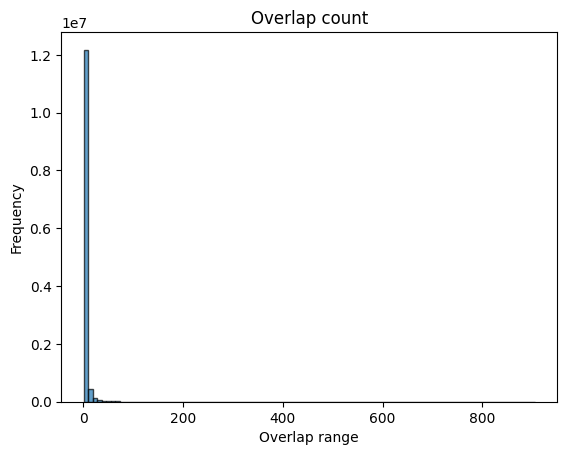

In [29]:
plt.hist(df['overlap'], bins=100, edgecolor='k', alpha=0.7)
plt.xlabel('Overlap range')
plt.ylabel('Frequency')
plt.title('Overlap count')
plt.show()

In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Example overlap_matrix (replace this with your actual matrix)
overlap_matrix = np.array([[2, 1, 2, 0],
                           [1, 3, 3, 0],
                           [2, 3, 4, 4],
                           [0, 0, 4, 5]])

# Get the shape of the matrix
num_rows, num_cols = overlap_matrix.shape

# Create a list to store the data in the desired format
data = []

# Initialize the progress bar
pbar = tqdm(total=num_rows * (num_rows - 1) // 2)  # Total number of combinations without duplicates

# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2,overlap):
    intersection = overlap
    union = set1+set2-overlap
    return intersection / union if union > 0 else 0

# Loop through the rows and columns of the matrix
for i in range(num_rows):
    for j in range(i + 1, num_cols):  # Start from i+1 to avoid duplicates
        overlap = overlap_matrix[i, j]
        if overlap > 0:
            data.append([i, j,overlap_matrix[i][i],overlap_matrix[j][j], overlap, jaccard_similarity(overlap_matrix[i][i], overlap_matrix[j][j],overlap)])
        pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['bundle id 1', 'bundle id 2','num_bundle 1', 'num_bundle 2', 'overlap', 'jaccard_similarity'])

# Print the DataFrame
print(df)

100%|██████████| 6/6 [00:00<00:00, 8229.50it/s]

   bundle id 1  bundle id 2  num_bundle 1  num_bundle 2  overlap  \
0            0            1             2             3        1   
1            0            2             2             4        2   
2            1            2             3             4        3   
3            2            3             4             5        4   

   jaccard_similarity  
0                0.25  
1                0.50  
2                0.75  
3                0.80  


In [18]:
print(overlap_matrix[1])

[1 0 3 0]


In [16]:
bi_overlap.toarray()

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 3., 0., 0.],
       [0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 5.]], dtype=float32)

In [7]:
# from gene_ii_asym import load_sp_mat

iui = load_sp_mat(f'datasets/{dataset_name}/iui_asym.npz')
print(iui.getnnz())
ibi = load_sp_mat(f'datasets/{dataset_name}/ibi_asym.npz')
print(ibi.getnnz())


ii_b_max = int(ibi.max())
print(ii_b_max)
ii_u_max = int(iui.max())
print(ii_u_max)


# bundle
print("statistic")
print("ii bundle")
lb1 = []
val1 = []
for i in range(1, 10):
    lb1.append(f'{i}')
    count = ibi.multiply(ibi == i).getnnz()
    val1.append(count)
    p = count / ibi.getnnz() * 100
    print("==", i, ":", p, "%")

count = ibi.multiply(ibi >= 10).getnnz()
val1.append(count)
lb1.append(f">={10}")
p = count / ibi.getnnz() * 100
print(">=", 10, ":", p, "%")


# user
print("ii user")
lb2 = []
val2 = []
for i in range(1, 10):
    lb2.append(f'{i}')
    count = iui.multiply(iui == i).getnnz()
    val2.append(count)
    p = count / iui.getnnz() * 100
    print("==", i, ":", p, "%")

count = iui.multiply(ibi >= 10).getnnz()
val2.append(count)
lb2.append(f">={10}")
p = count / ibi.getnnz() * 100
print(">=", 10, ":", p, "%")

83035234
354471
398
2587
statistic
ii bundle
== 1 : 93.50581570847827 %
== 2 : 3.5884458813273867 %
== 3 : 1.1374696378547187 %
== 4 : 0.5391132137748927 %
== 5 : 0.30467936728251394 %
== 6 : 0.1884498308747401 %
== 7 : 0.1385162679034392 %
== 8 : 0.10099556804364813 %
== 9 : 0.07870883654798277 %
>= 10 : 0.4178056879124103 %
ii user
== 1 : 72.02135059919263 %
== 2 : 14.45693402875218 %
== 3 : 5.43591892569364 %
== 4 : 2.67415637077629 %
== 5 : 1.5328215971547692 %
== 6 : 0.9644869550196006 %
== 7 : 0.6469482581334088 %
== 8 : 0.4560871111653639 %
== 9 : 0.3345615910470006 %
>= 10 : 0.4178056879124103 %


In [6]:
val1, val2

([331451, 12720, 4032, 1911, 1080, 668, 491, 358, 279, 1481],
 [59803097,
  12004349,
  4513728,
  2220492,
  1272782,
  800864,
  537195,
  378713,
  277804,
  1481])

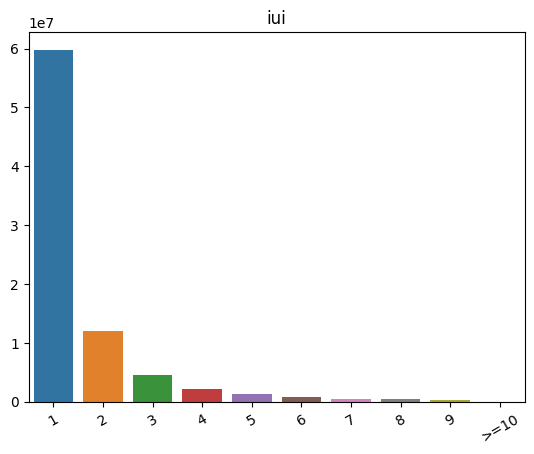

In [7]:
plt.title('iui')
temp1 = sns.barplot(x=lb2, y=val2)
temp1.set_xticklabels(temp1.get_xticklabels(), rotation=30)
plt.show()

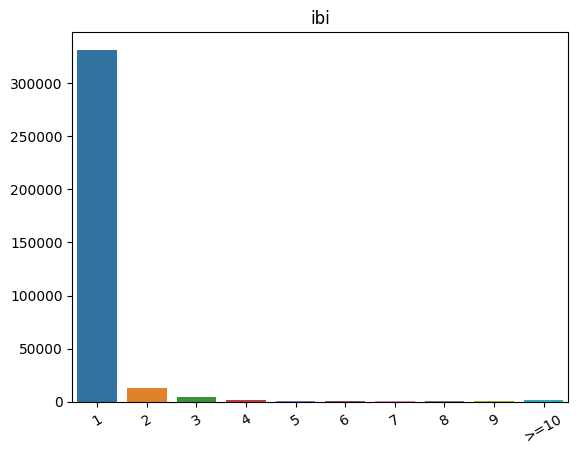

In [8]:
plt.title('ibi')
temp2 = sns.barplot(x=lb1, y=val1)
temp2.set_xticklabels(temp2.get_xticklabels(), rotation=30)
plt.show()

In [9]:
ub, ui, bi

(<53897x27694 sparse matrix of type '<class 'numpy.float32'>'
 	with 1213676 stored elements in Compressed Sparse Row format>,
 <53897x42563 sparse matrix of type '<class 'numpy.float32'>'
 	with 2290645 stored elements in Compressed Sparse Row format>,
 <27694x42563 sparse matrix of type '<class 'numpy.float32'>'
 	with 106916 stored elements in Compressed Sparse Row format>)

In [10]:
iu = ui.T
ib = bi.T
iu_count = iu.sum(axis=1)
ib_count = ib.sum(axis=1)

In [11]:
ib_count.max(), iu_count.max()

(398.0, 2587.0)

In [12]:
ib_count, iu_count

(matrix([[3.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]], dtype=float32),
 matrix([[11.],
         [45.],
         [36.],
         ...,
         [ 6.],
         [ 1.],
         [97.]], dtype=float32))

In [13]:
temp1 = []
labels = []
g = 0
th = 30
for i in range(0, th):
    v = (ib_count == i).sum()
    temp1.append(v)
    labels.append(f'{i}')
    print(v)
    g+=v
    
v = (ib_count >= th).sum()
temp1.append(v)
labels.append(f'>{th-1}')
print(v)
g+=v

0
26563
7196
3120
1643
936
606
465
338
253
178
154
138
110
73
87
78
49
49
39
24
39
25
28
20
18
12
20
9
12
281


In [14]:
temp2 = []
labels2 = []
g2 = 0
th2 = 30
for i in range(0, th2):
    v2 = (iu_count == i).sum()
    temp2.append(v2)
    labels2.append(f'{i}')
    print(v2)
    g+=v2
    
v2 = (iu_count >= th).sum()
temp2.append(v)
labels2.append(f'>{th-1}')
print(v)
g2+=v

2185
2465
2221
1976
1662
1456
1316
1193
1065
944
839
852
799
738
722
680
622
541
525
504
446
453
465
379
383
362
379
352
322
328
281


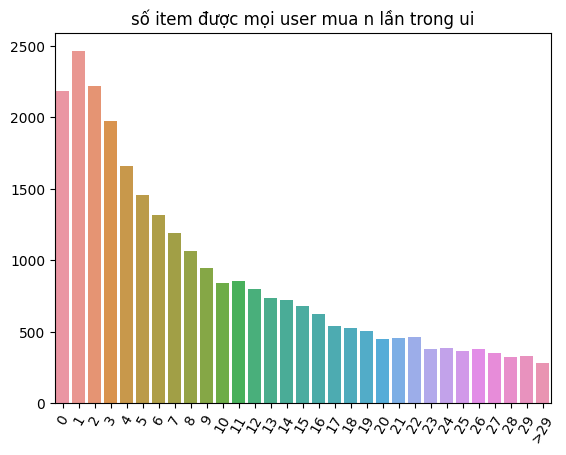

In [15]:
#  VD item 1 được mọi người mua 6 lần (mỗi người max 1 lần do cấu tạo dataset) -> cột 6: +1 
plt.title('số item được mọi user mua n lần trong ui')
iuc = sns.barplot(x=labels2, y=temp2)
iuc.set_xticklabels(iuc.get_xticklabels(), rotation=60)
plt.show()

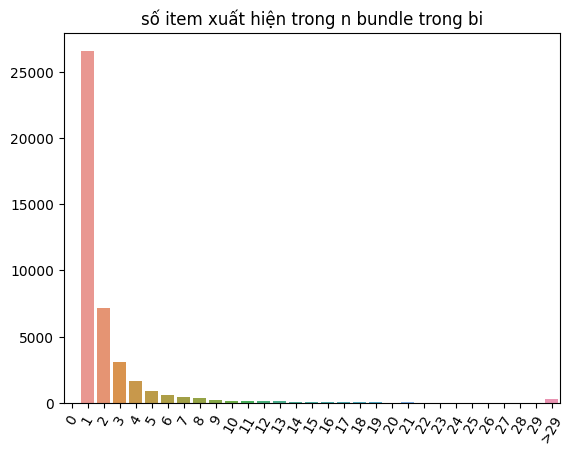

In [16]:
# VD item 4 xuất hiện trong bundle 2, 4, 6 -> cột 3: + 1
plt.title('số item xuất hiện trong n bundle trong bi')
ibc = sns.barplot(x=labels, y=temp1)
ibc.set_xticklabels(ibc.get_xticklabels(), rotation=60)
plt.show()

### New task 31/10


In [24]:
import pandas as pd
bi = pd.read_csv('/kaggle/working/CrossCBR_exp/datasets/iFashion/bundle_item.txt', delimiter = "\t",header = None, names = ['bundle_id','item_id'])

In [25]:
bi

,bundle_id,item_id
0,1253,2335
1,1253,8915
2,1253,11459
3,23951,8302
4,23951,18364
...,...,...
106911,2216,18134
106912,2216,37093
106913,23266,11540
106914,23266,18228


In [26]:
import itertools

# Assuming bundle_df is your DataFrame with columns "bundle_id" and "item_id"
# You can adapt this code to fit your specific DataFrame structure

unique_bundles = bi['bundle_id'].unique()
bundle_pairs = list(itertools.combinations(unique_bundles, 2))



# Now overlap_dict contains the overlaps for all possible bundle pairs

In [27]:
bi.describe

<bound method NDFrame.describe of         bundle_id  item_id
0            1253     2335
1            1253     8915
2            1253    11459
3           23951     8302
4           23951    18364
...           ...      ...
106911       2216    18134
106912       2216    37093
106913      23266    11540
106914      23266    18228
106915      23266    40047

[106916 rows x 2 columns]>

In [28]:
from tqdm import tqdm
overlap_dict = {}
count = 0
data=[]
for bundle1, bundle2 in tqdm(bundle_pairs):
    items_in_bundle1 = set(bi[bi['bundle_id'] == bundle1]['item_id'])
#     print(f"Bundle_id:{bundle1} ")
#     print(f"{items_in_bundle1}\n")
    items_in_bundle2 = set(bi[bi['bundle_id'] == bundle2]['item_id'])
#     print(f"Bundle_id: {bundle2}" )
#     print(f"{items_in_bundle2}\n")
    overlap = items_in_bundle1.intersection(items_in_bundle2)
    num_items_bundle1 = len(items_in_bundle1)
    num_items_bundle2 = len(items_in_bundle2)
    num_overlap_items = len(overlap)
    if num_items_bundle1 == 0 or num_items_bundle2 == 0:
        jaccard_ratio = 0.0
    else:
        jaccard_ratio = num_overlap_items / (num_items_bundle1 + num_items_bundle2 - num_overlap_items)
    if overlap:
        # Store the overlap in a dictionary with a unique key for each pair
#         print(overlap)
        data.append({'bundle_id1': bundle1, 'bundle_id2': bundle2, 'num_bundles1': num_items_bundle1, 'bum_bundles2': num_items_bundle2, 'overlap': num_overlap_items, 'jaccad': jaccard_ratio})
#         key = (bundle1, bundle2)
#         overlap_dict[key] = overlap
    count +=1
    # Store the overlap in a dictionary with a unique key for each pair
#     if count>1000:
#         break

  0%|          | 155949/383464971 [01:45<72:09:32, 1475.55it/s]

KeyboardInterrupt



In [22]:
# df = pd.DataFrame(data)

In [23]:
# df.head()